In [1]:
%load_ext autoreload
%autoreload 2

from functools import partial
from pathlib import Path

import cv2
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
import tensorflow as tf

from pitch_geo import data
import pitch_geo.models.augmentation as aug
from pitch_geo.data import KeyPointsDataset
from pitch_geo.data import read_image_and_keypoints
import vis_utils

# On single image

In [2]:
df = pd.read_csv('recruitment_task_pitch_geom/df_keypoints.csv')

df = df[df['dataset'] == 'train']

key = df.query('kid == 38 and vis != 0')['image_path'].item()
idx1 = df.query(f'kid == 39 and image_path == "{key}"').index
idx2 = df.query(f'kid == 38 and image_path == "{key}"').index
df.loc[idx1, 'x'] = df.loc[idx2, 'x'].item()
df.loc[idx1, 'y'] = df.loc[idx2, 'y'].item()
df.loc[idx1, 'vis'] = df.loc[idx2, 'vis'].item()

df = df[df['kid'] != 38]
df['kid'].nunique()

38

In [3]:
df['x'] = df['x'] / 1920
df['y'] = df['y'] / 1080
df['vis'] = (df['vis'] != 0).astype(np.float16)

In [4]:
sample_img_path = 'images/train/c814ce8e31e077df861c2848fe14fb.jpg'
image = cv2.imread(f'recruitment_task_pitch_geom/{sample_img_path}')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

keypoints = df[df['image_path'] == sample_img_path][['x', 'y', 'vis']].values

In [5]:
keypoints

array([[0.27708333, 0.1462963 , 1.        ],
       [0.90208333, 0.21018519, 1.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.18697917, 0.18796296, 1.        ],
       [0.3765625 , 0.21666667, 1.        ],
       [0.29375   , 0.27777778, 1.        ],
       [0.15104167, 0.37962963, 1.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.090625  , 0.23148148, 1.        ],
       [0.15625   , 0.24444444, 1.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.14375   , 0.31111111, 1.        ],
       [0.89479167, 0.35462963, 1.        ],
       [0.89166667, 0.43888889, 1.        ],
       [0.88645833, 0.55185185, 1.        ],
       [0.2921875 , 0.33148148, 1.        ],
       [0.69375   , 0.41018519, 1.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.

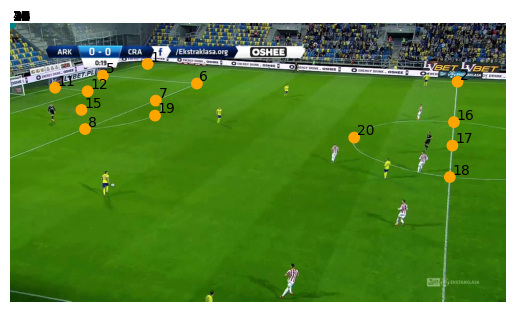

In [6]:
vis_utils.show_image_with_annotations(img=image, keypoints=keypoints, dot_radius= 20, normalized=True, vis=True)

# On tensorflow dataset

In [7]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 500
NUM_KEYPOINTS = 38  # 38 pairs each having x and y coordinates
DATA_FOLDER = Path('recruitment_task_pitch_geom')

AUTOTUNE = tf.data.AUTOTUNE

In [8]:
def load_image(
    path, image_size, num_channels, interpolation, crop_to_aspect_ratio=False
):
    """Load an image from a path and resize it. Taken from https://github.com/keras-team/keras/blob/v2.10.0/keras/utils/image_dataset.py#L30. """
    img = tf.io.read_file(path)
    img = tf.image.decode_image(
        img, channels=num_channels, expand_animations=False
    )
    if crop_to_aspect_ratio:
        img = image_utils.smart_resize(
            img, image_size, interpolation=interpolation
        )
    else:
        img = tf.image.resize(img, image_size, method=interpolation)
    img.set_shape((image_size[0], image_size[1], num_channels))
    return img


annotations_dict = data.df_to_dict2(df)

def get_annotations(image_path):
    # image_path is supposed to be bytes object
    all_annotatios = annotations_dict[image_path.numpy().decode('utf-8')]
    
    # For tranining, we are only interested in keypoints coordinates:
    return all_annotatios['keypoints']

In [9]:
images_paths = df['image_path'].unique()

train_paths, test_paths = train_test_split(images_paths, test_size=0.15, random_state=42, shuffle=True)

# train_df = df[df['image_path'].isin(train_paths)]
# val_df = df[~df['image_path'].isin(train_paths)]

train_absolute_paths = [str(DATA_FOLDER / p) for p in  train_paths]
train_paths = tf.data.Dataset.from_tensor_slices(train_paths)
train_files = tf.data.Dataset.from_tensor_slices(train_absolute_paths)

train_images = train_files.map(
    partial(
        load_image, 
        image_size=(IMG_SIZE, IMG_SIZE),
        num_channels=3,
        interpolation='bilinear'        
    )
)
# train_images = train_images.map(lambda x: x/255).cache()

# Wrapping this inside tf.py_function s necessary. Otherwise TF throws AttributeError: 'Tensor' object has no attribute 'numpy'
train_labels = train_paths.map(lambda file_name: tf.py_function(get_annotations, [file_name], [tf.float16]))
# train_labels = train_labels.map(lambda x: tf.divide(x, IMG_SIZE))

# train_ds = tf.data.Dataset.zip((train_images, train_labels))

# train_ds = train_ds.shuffle(4000).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

2022-11-20 15:01:25.360805: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-20 15:01:25.396063: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-20 15:01:25.396459: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-20 15:01:25.398436: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

# My custom augmentations

In [10]:
tf.data.experimental.enable_debug_mode()

In [11]:
sample_img_path

'images/train/c814ce8e31e077df861c2848fe14fb.jpg'

In [12]:
train_images = train_files.map(
    partial(
        load_image, 
        image_size=(IMG_SIZE, IMG_SIZE),
        num_channels=3,
        interpolation='bilinear'        
    )
)
# train_images = train_images.map(lambda x: x/255)

# Wrapping this inside tf.py_function s necessary. Otherwise TF throws AttributeError: 'Tensor' object has no attribute 'numpy'
train_labels = train_paths.map(lambda file_name: tf.py_function(get_annotations, [file_name], [tf.float16])).map(lambda x: tf.reshape(x, (38, 3)))
# train_labels = train_labels.map(lambda x: tf.divide(x, tf.constant([1920., 1080.], dtype=tf.float16)))

train_ds_ = tf.data.Dataset.zip((train_images, train_labels))
# batch = next(iter(train_ds))
# train_ds = train_ds.shuffle(4000).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

In [13]:
batch = next(iter(train_ds_))
batch[1]

<tf.Tensor: shape=(38, 3), dtype=float16, numpy=
array([[0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    ],
       [0.9443, 0.588 , 1.    ],
       [0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    ],
       [0.0917, 0.6064, 1. 

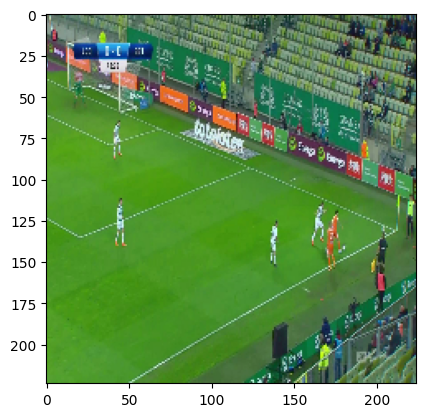

In [124]:
img_rot, kps_rot = aug.random_rotate(batch[0].numpy(), batch[1].numpy(), 10, (0.5, 0.8))
plt.imshow(img_rot / 255.)

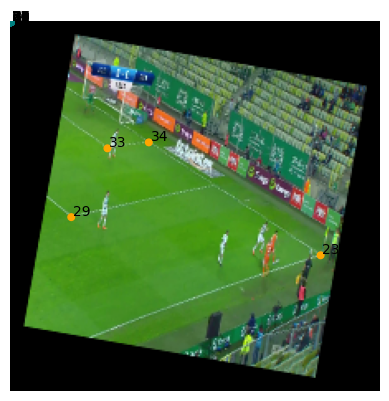

In [106]:
vis_utils.show_image_with_annotations(img=img_rot / 255, keypoints=kps_rot, dot_radius= 2, normalized=True, vis=True)

In [75]:
mtx.shape

(2, 3)

In [76]:
keypoints.shape

(38, 3)

In [102]:
keypoints[:, :2]

array([[0.27708333, 0.1462963 ],
       [0.90208333, 0.21018519],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.18697917, 0.18796296],
       [0.3765625 , 0.21666667],
       [0.29375   , 0.27777778],
       [0.15104167, 0.37962963],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.090625  , 0.23148148],
       [0.15625   , 0.24444444],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.14375   , 0.31111111],
       [0.89479167, 0.35462963],
       [0.89166667, 0.43888889],
       [0.88645833, 0.55185185],
       [0.2921875 , 0.33148148],
       [0.69375   , 0.41018519],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.

In [103]:
keypoints2 = np.hstack([keypoints[:, :2], np.ones((38))])
keypoints2

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)

In [87]:
(mtx @ keypoints.T).T.shape

(38, 2)

In [81]:
np.tensordot(mtx, keypoints, axes=-1).shape

(2, 3, 38, 3)

In [57]:
kp = batch[1].numpy()[-5][:2]
kp

array([0.3062, 0.312 ], dtype=float16)

In [63]:
mtx

array([[ 0.7878462 , -0.13891854,  0.17553617],
       [ 0.13891854,  0.7878462 ,  0.03661763]])

In [69]:
np.dot(mtx, np.array([*kp, 1.]))

array([0.37339292, 0.32496511])

In [66]:
a = np.array([[ 5, 1 ,3], 
                  [ 1, 1 ,1], 
                  [ 1, 2 ,1]])
b = np.array([1, 2, 3])
print (a.dot(b))

[16  6  8]


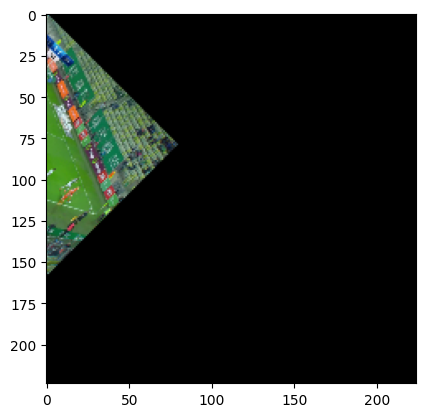

In [24]:
plt.imshow(img_rot / 255.)

In [52]:
train_ds = train_ds_.map(
    lambda image, keypoints: tf.numpy_function(func=aug.random_translate, inp=[image, keypoints, 0.5], Tout=[tf.float32, tf.float16]),
    num_parallel_calls=AUTOTUNE
)
# train_ds = train_ds.batch(2).prefetch(buffer_size=AUTOTUNE)
batch = next(iter(train_ds))
# vis_utils.show_image_with_annotations(batch[0].numpy(), batch[1].numpy(), normalized=True, dot_radius=3)

DEBUG: randomly translating
DEBUG: randomly translating by x=-6 y=76
DEBUG mask=array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False,  True, False, False, False,  True,  True, False, False,
       False, False])
DEBUG: keypoints[mask, :2]=array([[0.919 , 0.9253],
       [0.0664, 0.944 ],
       [0.1466, 0.694 ],
       [0.2808, 0.6494]], dtype=float16)


In [43]:
batch[1].numpy()

array([[0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    ],
       [0.9443, 0.588 , 1.    ],
       [0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    ],
       [0.0917, 0.6064, 1.    ],
       [0.    , 0.    , 0.    ],
       [0.

DEBUG: randomly translating
DEBUG: randomly translating by x=-29 y=62
DEBUG mask=array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False,  True, False, False, False,  True,  True, False, False,
       False, False])
DEBUG: keypoints[mask, :2]=array([[ 0.8154 ,  0.865  ],
       [-0.03738,  0.884  ],
       [ 0.04282,  0.634  ],
       [ 0.1771 ,  0.5894 ]], dtype=float16)


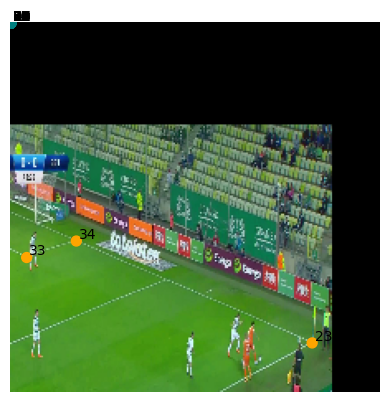

In [53]:
batch = next(iter(train_ds))
vis_utils.show_image_with_annotations(
    batch[0].numpy() / 255., batch[1].numpy(), normalized=True, dot_radius=3, vis=True
)

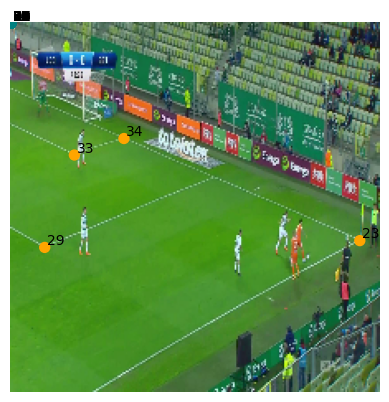

In [56]:
batch = next(iter(train_ds))
vis_utils.show_image_with_annotations(
    batch[0].numpy() / 255., batch[1].numpy(), normalized=True, dot_radius=3, vis=True
)

In [17]:
train_ds = (
    train_ds_
    .shuffle(4000)
    .map(
        lambda image, keypoints: tf.numpy_function(func=random_translate, inp=[image, keypoints, 0.3], Tout=[tf.float32, tf.float16]),
        num_parallel_calls=AUTOTUNE
    )
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=AUTOTUNE)
)
batch = next(iter(train_ds))

In [12]:
batch = next(iter(train_ds_))

In [14]:
batch[0]

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[ 95.783165, 116.64286 , 109.75128 ],
        [ 94.18878 ,  95.359695,  69.84184 ],
        [ 48.37507 , 148.02432 , 151.63142 ],
        ...,
        [ 65.27439 ,  68.77427 ,  62.202736],
        [ 39.178642,  78.893   , 108.821465],
        [ 45.998417,  62.35831 ,  54.731987]],

       [[ 95.692604, 118.12118 , 105.90689 ],
        [122.58291 , 114.15434 ,  94.08292 ],
        [118.75136 , 182.16461 , 171.46687 ],
        ...,
        [ 70.40957 ,  71.69521 ,  67.07005 ],
        [ 28.89289 ,  72.60725 , 105.      ],
        [ 74.8645  ,  87.10703 ,  76.8928  ]],

       [[ 97.22577 , 119.98852 , 102.57143 ],
        [105.144135, 113.26658 ,  89.08801 ],
        [196.05104 , 235.3074  , 201.58672 ],
        ...,
        [ 69.87262 ,  68.52563 ,  68.749985],
        [ 21.62493 ,  54.409313,  94.050804],
        [ 79.42238 , 101.554   ,  87.120544]],

       ...,

       [[ 86.      , 162.      ,  54.      ],
        [ 86.

In [16]:
for i, batch in enumerate(train_ds):
    print(f'{i + 1}/{len(train_ds)}', end='\r')
    continue

In [16]:
batch

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.2848038 , 0.5558826 , 0.15539204],
         [0.27965695, 0.5449584 , 0.14751376],
         [0.29012528, 0.5531856 , 0.17706479],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],
 
        [[0.27920175, 0.5693978 , 0.13410369],
         [0.28078672, 0.5618299 , 0.13069218],
         [0.28167766, 0.5522659 , 0.13573924],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],
 
        [[0.26309574, 0.56096965, 0.13482921],
         [0.267602  , 0.5629555 , 0.13641477],
         [0.2674369 , 0.55364126, 0.14208697],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],
 
        ...,
 
        [[0.        , 0.        

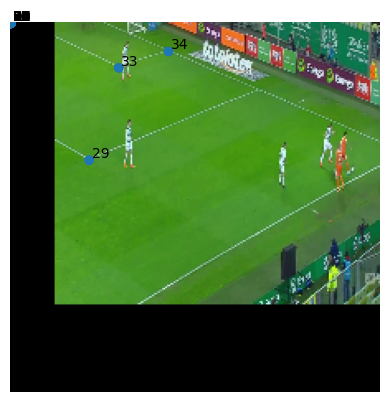

In [14]:
batch = next(iter(train_ds))
vis_utils.show_image_with_annotations(batch[0].numpy(), batch[1].numpy(), normalized=True, dot_radius=3)